In [1]:
import ast
import binascii
import gzip
import io
import json
import nilearn
import os
import pathlib
import tarfile
import zipfile

from collections import Counter
from io import BytesIO
from io import StringIO
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting
from nilearn.plotting import plot_anat
from nilearn.plotting import find_probabilistic_atlas_cut_coords as find_cut_coords
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin

import nibabel as nib
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pathlib import Path

import loadutils as lu
# import sniffbytes as snif
# import scanzip

datalad_config_path = Path(xpu('~/../../data/cisl/DATA/cimaq_20190901/.datalad/config'))
cimaq_path = xpu('~/../../data/cisl/DATA/cimaq_20190901')
env_packages = xpu('~/py369env/bin')

/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
subs = df(sorted(list((itm, sorted(visit for visit in
                                   ls(pjoin(cimaq_path, itm))
                                   if '-V03' in visit))
                   for itm in ls(cimaq_path)
                   if itm.startswith('sub-'))),
          columns = ['sub_ids', 'visits'])

subs = subs.iloc[[row[0] for row in subs.iterrows()
                  if row[1].visits != []]]
subs['visits'] = [row[1].visits[0] for row
                  in subs.iterrows()]

scan_names = Counter(lu.flatten(tuple(ls(pjoin(cimaq_path,
                                row[1].sub_ids,
                                row[1].visits))
                       for row in subs.iterrows())))

subs['scan_names'] = [sorted(ls(pjoin(cimaq_path, row[1].sub_ids,
                                      row[1].visits)))
                    for row in subs.iterrows()]
subs['is_full'] = [len(row[1].scan_names) == 4
                   for row in subs.iterrows()]
# list(scan_names.keys())
subs = subs.drop([row[0] for row in subs.iterrows()
                  if not row[1].is_full])

subs[list(scan_names.keys())] = [[sorted(lu.loadimages(pjoin(cimaq_path, row[1].sub_ids,
                                      row[1].visits, aname))
                                       ) for aname in scan_names.keys()]
                                 for row in subs.iterrows()]

subs

,sub_ids,visits,scan_names,is_full,func,fmap,dwi,anat
1,sub-3025432,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
2,sub-3123186,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
3,sub-3149469,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
4,sub-3163875,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
5,sub-3186603,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
...,...,...,...,...,...,...,...,...
173,sub-9322528,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
174,sub-9417188,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
175,sub-9494076,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...
176,sub-9648306,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...


In [8]:
# Anatomical

reference = pd.Series([itm for itm in
                       subs.anat.iloc[0]
                       if '.nii' in itm]).sample(1)
sources = [itm for itm in
           subs.anat.iloc[0][1:]
           if '.nii' in itm]
resampled = [nilearn.image.resample_to_img(source_img=source,
                                           target_img=reference,
                                           interpolation='continuous',
                                           copy=True,
                                           order='F',
                                           clip=False,
                                           fill_value=0,
                                           force_resample=False)
             for source in sources if '.json' not in source]

In [9]:
func_niftis = sorted([itm for itm in subs.iloc[0].func
                      if '.nii' in itm])

In [10]:
# DiFuMo Atlas as mask
map_1034_3mm = xpu('~/py369env/bin/DiFuMo/1024/1024/3mm/maps.nii.gz')

atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(
                           map_1034_3mm) 


In [11]:
masker = NiftiMapsMasker(map_img=map_1034_3mm,
                         standardize=True,
                         memory='nilearn_cache',
                         memory_level=1,
                         verbose=5)


In [13]:
time_series = masker.fit_transform(func_niftis[1],
                                   confounds=None)

[NiftiMapsMasker.fit_transform] loading regions from /home/fnadeau/py369env/bin/DiFuMo/1024/1024/3mm/maps.nii.gz
Resampling maps
[Memory]28.4s, 0.5min   : Loading resample_img...
________________________________________resample_img cache loaded - 5.9s, 0.1min
[Memory]35.5s, 0.6min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [69]:
labels = pd.read_csv(xpu('~/py369env/bin/DiFuMo/1024/1024/labels_1024_dictionary.csv'))
labels

,Component,Difumo_names,Yeo_networks7,Yeo_networks17,GM,WM,CSF
0,1,Retrocalcarine cortex RH,VisCent,VisCent,0.448141,0.536476,0.015397
1,2,Superior longitudinal fasciculus II mid-poster...,No network found,No network found,0.017326,0.982661,0.000024
2,3,Arcuate fasciculus mid-anterior RH,DorsAttnB,ContA,0.502915,0.473717,0.023376
3,4,Cerebrospinal fluid (between middle frontal gy...,ContA,SalVentAttnB,0.400989,0.023640,0.125466
4,5,Precentral sulcus mid-inferior RH,DorsAttnB,ContA,0.668818,0.199817,0.120609
...,...,...,...,...,...,...,...
1019,1020,Parieto-occipital sulcus anterior RH,VisCent,DefaultC,0.747118,0.157032,0.095855
1020,1021,Cerebellum IX,No network found,No network found,0.578940,0.142701,0.144514
1021,1022,Cuneus postero-inferior LH,VisCent,VisPeri,0.518821,0.169658,0.238200
1022,1023,Caudate superior anterior,No network found,No network found,0.699400,0.054205,0.246384


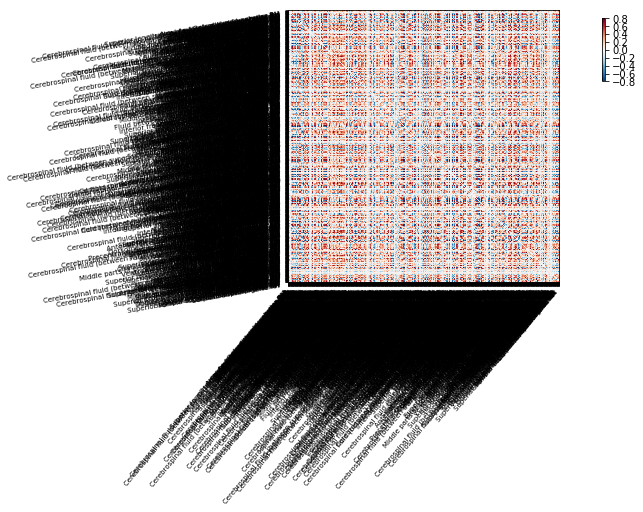

In [72]:
# Build and display a correlation matrix

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Display the correlation matrix

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     labels=labels.Difumo_names.values,
                     colorbar=True,
                     vmax=0.8,
                     vmin=-0.8)



In [ ]:
coords = atlas_region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix,
                         coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

/home/fnadeau/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(<nibabel.nifti1.Nifti1Image at 0x7f54b5b03ef0>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f54b2e57cc0>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b03f98>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f557358c160>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b7e1a208>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5573271588>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b5ac18>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5572c4f9b0>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b5a9b0>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f557265add8>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b03588>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5571db8198>)]

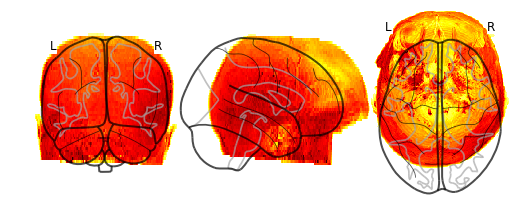

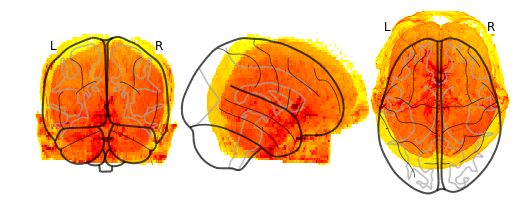

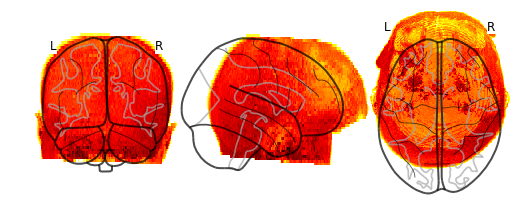

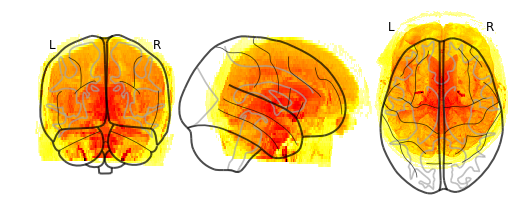

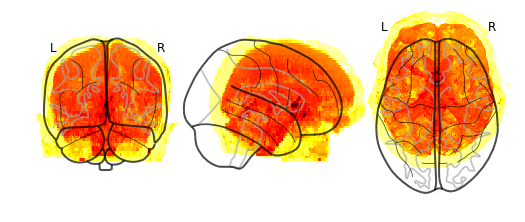

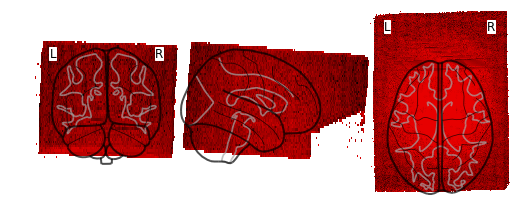

In [47]:
[(brain, plotting.plot_glass_brain(brain))
 for brain in resampled]

In [16]:
def get_mean_anat(images):
    for image in enumerate(images):
        nilearn.image.resample_to_img(source_img=image,
                                      target_img,
                                      interpolation='continuous',
                                      copy=True,
                                      order='F',
                                      clip=False,
                                      fill_value=0,
                                      force_resample=False)

SyntaxError: positional argument follows keyword argument (<ipython-input-16-77cb17c70025>, line 4)

In [12]:
maskpaths = df(tuple((img, pjoin(cimaq_path,
                                 subs.iloc[0].sub_ids,
                                 subs.iloc[0].visits,
                                 'anat', img))
                     for img in subs.iloc[0].anat
                     if '.nii' in img),
               columns = ['scan_names', 'scan_paths'])

maskpaths['to_resample'] = [[scan for scan in
                             maskpaths.scan_paths
                             if bname(scan) not in row[1].scan_paths]
                            for row in maskpaths.iterrows()]
# maskpaths.iloc[0].to_resample, maskpaths.iloc[0].scan_names
maskpaths['to_resample'].values

array([list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_PD.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T1w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2star.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_mod-T1w_defacemask.nii.gz']),
       list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_FLAIR.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T1w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2star.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/su

In [13]:
maskpaths_func = df(tuple((img, pjoin(cimaq_path,
                                 subs.iloc[0].sub_ids,
                                 subs.iloc[0].visits,
                                 'func', img))
                     for img in subs.iloc[0].func
                     if '.nii' in img),
               columns = ['scan_names_func', 'scan_paths'])

maskpaths_func['to_reseample_func'] = [[scan for scan in
                             maskpaths_func.scan_paths
                             if bname(scan) not in row[1].scan_paths]
                            for row in maskpaths_func.iterrows()]
# maskpaths_func.iloc[0].to_reseample_func, maskpaths_func.iloc[0].scan_names_func
maskpaths_func['to_reseample_func'].values



array([list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz']),
       list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-memory_bold.nii.gz'])],
      dtype=object)

In [14]:
plotting.plot_glass_brain('/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz')

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

In [6]:
time_series

NameError: name 'time_series' is not defined

In [ ]:
def get_fulltarcontents(mytar):
    return pd.concat([df.from_dict(tarmember.get_info(),
                                   orient='index').T
                              for tarmember in
                              mytar.getmembers()]).sort_values(
                        'name').reset_index(drop = True).iloc[1:220,:]

In [3]:
def get_series_uids(mytar):
    return pd.concat([df.from_dict(tarmember.get_info(),
                                   orient='index').T
                              for tarmember in
                              mytar.getmembers()]).sort_values(
                        'name').reset_index(drop = True).iloc[-1,:]['name']

In [75]:
tarfile_contents = pd.read_csv('~/cimaq_memory/tarfile_contents.tsv',
                               sep = '\t').set_index(
                                   'Unnamed: 0').reset_index(drop = True)


tarfile_contents['split_basenames'] = [ast.literal_eval(row[1].split_basenames)
                                       if 'CIMAQ' not in row[1].split_basenames
                                       else {'dates': \
                                             row[1].basenames.split('_')[1],
                                             'archv_names': \
                                             '_'.join(row[1].basenames.split('_')[2:])}
                                       for row in tarfile_contents.iterrows()]

tarfile_contents = pd.concat([tarfile_contents,
                              df(tarfile_contents['split_basenames'].values.tolist())],
                             axis = 1)

# Saving
# tarfile_contents.to_csv('~/cimaq_memory/tarfile_contents.tsv',
#                         sep = '\t', encoding = 'UTF-8')

tarfile_contents['inner_contents'] = \
    [df.from_dict(mytar.getmember(row[1].names).get_info(),
                  orient = 'index').T.squeeze()
     for row in tarfile_contents.iterrows()]

series_uids_pscid = pd.read_csv('series_uids_pscid.tsv',
                                sep = '\t').set_index(
                        'Unnamed: 0').reset_index(drop = True)
series_uids_pscid = series_uids_pscid.rename(columns = {'0': 'sub_id',
                                                        '1': 'series'})
# ast.literal_eval(series_uids_pscid.iloc[0].series)
# key example ["('3002498', '327986')"] or ["('3025432', '658178')"]
vals = df(dict(tuple(('_'.join(itm[0]),
               df(itm[1].splitlines()))
              for itm in
              series_uids_pscid.values.tolist(
              ))).values()).values.tolist()
subids = ['_'.join([itm.strip() for itm in
                    itm.replace('(','').replace(
                        ')','').replace("'", '').split(',')])
          for itm in series_uids_pscid.sub_id.values.tolist()]

test = df.from_dict(dict(tuple(zip(subids, vals))),
             orient = 'index')
dict(tuple(zip(subids,
               [itm[0][1:].values for itm
                in test[0].values.tolist()])))
# Saving
# test.to_csv('~/cimaq_memory/series_uids_pscid_ordered.tsv',
#                                       sep = '\t', encoding = 'UTF-8')

In [4]:
## getting clean credentials

# name, value = datalad_config_path.read_text().splitlines()
# newname=name.replace(']', '').replace(
#             '[', '').replace('"', '').replace(' ', '_')
# newvalue = value[value.find('= ')+2:]
# datalad_credentials = ast.literal_eval(''.join(['{"', str(newname),
#                           '"', ' : "', newvalue, '"}']))
# with open(xpu('~/Documents/datalad_credentials.json'), 'w') as jfile:
#     json.dump(fp=jfile,
#               obj=datalad_credentials)
# jfile.close()


In [5]:
# extractedpath = '~/mytar_extracted/cimaq_dicoms_20190901/'
# seriesuids_test = next((pjoin(extractedpath, itm)
#                         for itm in ls(extractedpath)))

# series_uids = pd.read_csv(StringIO(Path(
#                     seriesuids_test).read_text()),
#                           sep = '\t')

# series_uids

In [6]:
# series_uids_pscid = df(tuple(((str(grp), str(series_uids.groupby('PSCID').get_group(
#                                 grp)['CandID'].unique().tolist()[0])),
#                               series_uids.groupby('PSCID').get_group(grp).iloc[:, 2:])
#                              for grp in series_uids.groupby('PSCID').groups))
# series_uids_pscid

In [7]:
# series_uids_pscid_dict = repr(series_uids_pscid.set_index(0).T.to_dict())
# series_uids_pscid_dict                       

In [8]:
# Path('~/series_uids_pscid2.json').write_text(
#      series_uids_pscid_dict,
#      encoding = 'UTF-8')


In [9]:
# series_uids_pscid.to_csv('~/series_uids_pscid.tsv',
#                          sep = '\t',
#                          encoding = 'UTF-8')

In [10]:
# series_uids.to_csv('~/series_uids.tsv',
#                    sep = '\t',
#                    encoding = 'UTF-8')

# sourcedata_path=Path(pjoin(dname(dname(datalad_config_path)),
#                 'sourcedata/cimaq_dicoms_20190901_v3.tar.gz'))

# sourcedata_path.parent.as_posix()

# mytar=tarfile.open(sourcedata_path)
# tarfile_contents = get_fulltarcontents(mytar)

# tarfile_contents['names'] = [str(aname) for aname in
#                              tarfile_contents.name]
# tarfile_contents['basenames'] = [bname(name).strip() for name
#                                  in tarfile_contents.names]
# tarfile_contents['split_basenames'] = [dict(tuple(zip(('dates', 'archv_names'),
#                                                  name.split('_')[1:])))
#                                        for name in tarfile_contents.basenames]
# tarfile_contents['split_basenames']

# tarfile_contents.to_csv('~/tarfile_contents.tsv',
#                         sep = '\t',
#                         encoding = 'UTF-8')